In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict

from nose.tools import *
from scipy.stats import normaltest,median_absolute_deviation

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer,precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA,IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LinDA
from sklearn.manifold import Isomap
from functools import reduce
from sklearn import metrics
import pickle
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif,mutual_info_regression,SelectPercentile
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# Mechanisms of Action Prediction Competition

Shared link on google drive (shared to iordan93@)
https://drive.google.com/drive/folders/17pTOVLpfSbLpPC24ggleNfIKi2sLOg3Y?usp=sharing

GitHub (without the feature csv file as it exceeds 100 MB)
https://github.com/Ynche/MoA

#### Abstract
Essentially, MoA is  an evaluation of a drug performance. After taking of a drug (or taking a placebo) gene expressions and cell features are measured: 872 features in total. Correspondingly, the target is the protein trigger, denoted by 1 (trigger) and 0 (no trigger). The target are 206 proteins which are measured separately. Several targets might be triggered which denotes the task as multi-label. 
Two problems constitue the main challenge - first, sparsity of data (imbalanced categories) where most of the target columns have less than 1% positive records and second, feature abundance. Feature selection is impeded by lack of linear correlation between features and mainly by problem one - imbalanced categories.
Due to lack of computational capacities 6 targets out of 206 are selected (from left tail, median and right tail). Five models are tested - Logistic, Logistic with over and under sampling, Linear SVM with mutual_info_classif feature selection, Random forest, Logistic with PCA. Neither of the models proves to be valuable in predicting protein trigger.

### Content

#### 1. Data Overview
   1.1 Feature Attributes.
   
   1.2 Targets.
   
   1.3 Project Challenges.
   
   1.4 Data Preprocessing.
   
#### 2. Methodology
   2.0 Target and Feature Preprocessing.
   
   2.1 Target Selection: Simplified procedure in the context of lack of computational capacities.
   
   2.2 Feature Engineering: Dummy Variables for Categorical Data.
   
   3.0 Models. 
   
   3.1 Logistic Regression. 
   
   3.2 Linear SVM with Feature Selection.
   
   3.3 Random Forest.
   
   3.4 Logistic Regression with Under and Over Sampling.
   
   3.5 Models Performace.

#### 3. Bibliography



### 1.Data Overview

  Mechanism of Action describes the process by which a molecule (a drug in this case), functions to produce a pharmacological effect. A drug’s mechanism of action may refer to its effects on a biological readout such as cell growth, or its interaction and modulation of its direct biomolecular target, for example a protein or nucleic acid. 
  Data in current study is collected through a cell-based assay designed to capture gene expression and cell viability levels. An assay is an investigational tool used in biology and chemistry for the detection or measurement of a target molecule's presence or functional activity. Based on the patterns in the data, the task is to predict a drug's mechanism of action (MoA). An important point is that the competition is a multi-label competition, not multi-class, meaning that some rows can be associated with multiple targets.
   
   The measurement of gene expression is based on the L1000 assay. Reference on how it works:
https://clue.io/connectopedia/what_is_l1000
   
   The measurement of cell viability is based on the PRISM assay. Reference on how it works:
https://www.luminexcorp.com/blog/prism-a-novel-bead-based-biological-barcode-assay/
   
   #### 1.1Feature Attributes:
   
   1. 772 gene expression features, each denoted by "g-". Each gene feature represents the expression of one particular gene. Therefore, there are 772 individual genes being monitored. (Float in the range -10 to 10)
   2. 100 cell viability features, each denoted by "c-". Each cell feature represents the viability of one particular cell line. (Float in the range -10 to 10)
   3. In addition to the data collected from the assay, there are three columns explaining the experiment type, dosing, and measurement time.
   - Treatment/Control - The cp_type column indicates whether the experiment is a treatment and contains drug or control (contains no drug). The control group is 8% from data. (trt_cp - treatment, ctl_vehicle - control)
   - Dosage - The cp_dose column indicates the dose level used in the experiment. Generally, a higher dose will have a stronger effect. (D1 - small dose, D2 - high dose)
   - Timing - The cp_time column indicates the amount of time elapsed between adding the drug and when the measurement was taken. For example, some drugs will have an irreversible effect that can still be seen 72 hours after dosing. Other drugs will have lost all effect by that point and may be indistinguishable from controls. (Integer in the range 24 to 72 hours)
   
   Number of signatures: 23814
   Each signature in the dataset is made out of 2 replicates (identical experiments with the same drug) that were collapsed into one vector of values.
   
   #### 1.2 Targets:
   
   1. 206 target attributes that represent protein measurement represented as binary data (0 and 1). The target can be interpreted either as a probability of an event (0% or 100%) or two categories. Data is highly unbalanced. The targets that have 238 or less possitive records are 184, meaning that for these 184 columns, the ratio ones to zeroes is less than 1 to 99. 
   
   #### 1.3 Project Challenges:
   
   There are two significant challenges that the project imposes:

   1. Imbalanced target.
   The positive category is highly underrepresented. Some models are not robust to unbalanced categories. Possible correction is combination of under and over sampling  with the creation of synthethic observations. Logistic model is tested with the under and over sampling strategy.
   
   2. High dimensionality of features. 
   There are 875 features with no linear correlation among them. Although there are 23814 observations, the target is highly imbalanced which reduces the informational gain and thus, the feature selection process. 
   
   #### 1.4 Data Preprocessing
   
   The gene expression features and cell viability features are normalized using quantile normalization. In the context of measurement of gene expression, the quantile normalization is used to remove the effect of different light bulbs intensity used for different experiments. The new values have the same distribution and the original ranking order of the observations is preserved. The outliers have been normalized using a robust z-score (x-median)/(median absolute deviation * 1.4826). The data is clipped to have min of -10 and max 10.
   
   https://www.youtube.com/watch?v=ecjN6Xpv6SE
   
   The treatment,dosage and timing are converted to dummy variables. The baseline groups are excluded as follows: 'cp_type_ctl_vehicle', 'cp_time_24','cp_dose_D1'.
   

In [3]:
train_features = pd.read_csv("train_features.csv/train_features.csv",sep=',',index_col=[0])
train_features.head(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
train_targets = pd.read_csv("train_targets_scored.csv/train_targets_scored.csv",sep=',',index_col=[0])
train_targets.head(5)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print("Shape of train features:",train_features.shape)
print("Shape of train targets:",train_targets.shape)

Shape of train features: (23814, 875)
Shape of train targets: (23814, 206)


In [7]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [8]:
train_targets.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Perfoming a check for missing values. There are no missing values for both features and target.

In [9]:
train_miss_features=train_features.isnull().sum().sum()
train_miss_targets=train_targets.isnull().sum().sum()
print("Missing train features:",train_miss_features)
print("Missing train targets:",train_miss_targets)

Missing train features: 0
Missing train targets: 0


There are 872 float features in the range of -10 to 10 and 3 categorical features. We check which are the unique categories for the three categorical features.

In [6]:
print("Unique categories for dose:",train_features.cp_dose.unique())
print("Unique categories for treatment:",train_features.cp_type.unique())
print("Unique categories for drug timing:",train_features.cp_time.unique())

Unique categories for dose: ['D1' 'D2']
Unique categories for treatment: ['trt_cp' 'ctl_vehicle']
Unique categories for drug timing: [24 72 48]


Out of curiosity we check what is the percentage of the control group taking the placebo ~ 8%.

In [10]:
train_features.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [27]:
def percent_ones_columns(df,percent_ones):
    """Counts the number of features with less or equal percentage of Positive records. Used for dummy/binary data"""
    ones= np.count_nonzero(df==1, axis=0)
    df_ones = pd.DataFrame({'Count_ones':ones/df.shape[0]})
    sum_ones= (df_ones<=percent_ones).sum()
    return f'Number of columns that have equal or less than {percent_ones*100}% Positive records:{repr(sum_ones)}'

In [28]:
percent_ones_columns(train_targets,0.01)

'Number of columns that have equal or less than 1.0% Positive records:Count_ones    184\ndtype: int64'

In [16]:
def histogram_binary_data(df,zero_or_one,bins,x_label,y_label,xlim_min=None,xlim_max=None):
    """Histogram of distribution of ones or zeros for dummy/binary data."""
    np_ones= np.count_nonzero(df==zero_or_one, axis=0)
    df_ones = pd.DataFrame({'Count_ones':np_ones})
    plt.hist(df_ones['Count_ones'],bins=bins)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim_min,xlim_max)
    return

As expected, the the target variables are highly unbalanced.

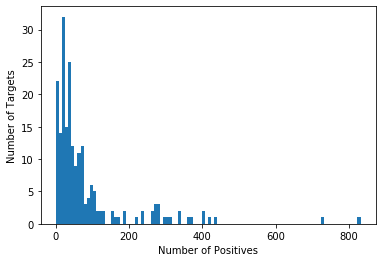

In [20]:
histogram_binary_data(train_targets,1,100,'Number of Positives','Number of Targets',xlim_min=None,xlim_max=None)

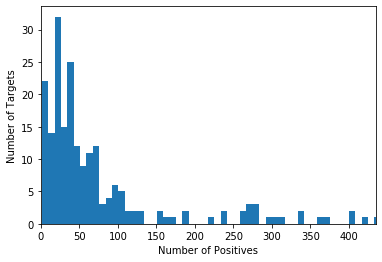

In [21]:
histogram_binary_data(train_targets,1,100,'Number of Positives','Number of Targets',xlim_min=0,xlim_max=435)

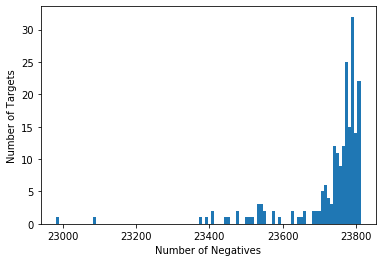

In [23]:
histogram_binary_data(train_targets,0,100,'Number of Negatives','Number of Targets',xlim_min=None,xlim_max=None)

In [20]:
ones= np.count_nonzero(train_targets==1, axis=0)
ones.sort()
np.unique(ones,return_counts=True)

(array([  1,   6,   7,  12,  13,  17,  18,  19,  23,  24,  25,  26,  29,
         30,  31,  32,  35,  36,  37,  38,  39,  42,  43,  44,  47,  48,
         49,  50,  51,  54,  55,  56,  59,  60,  61,  62,  66,  67,  68,
         71,  72,  73,  74,  80,  84,  85,  89,  92,  93,  96,  97,  98,
        102, 103, 104, 106, 115, 119, 121, 127, 130, 151, 158, 165, 170,
        190, 192, 223, 236, 241, 264, 266, 267, 270, 273, 279, 281, 283,
        297, 301, 316, 336, 340, 360, 367, 402, 404, 424, 435, 726, 832],
       dtype=int32),
 array([ 2, 16,  4, 11,  2,  1, 13,  4,  2,  5,  8,  3,  1,  6,  4,  1,  1,
        12,  6,  1,  1,  4,  1,  1,  1,  7,  1,  1,  1,  3,  2,  2,  1,  3,
         3,  2,  1,  2,  1,  1,  3,  5,  2,  2,  1,  1,  2,  1,  1,  3,  1,
         1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1]))

In [34]:
def subplot_grid(rows,cols,bins,x_label,y_label,figsize,feature_list): 
    """Histogram of features with the option to choose number of features to be displayed and in what format: number of rows and """
    if len(feature_list)!=rows*cols:
        raise Exception("Feature list length must correspond to plot size")
    fig, axs = plt.subplots(rows, cols,figsize=(figsize[0],figsize[1]))
    index = 0
    for row in range(rows):
        for col in range(cols):
            axs[row, col].hist(train_features[feature_list[index]],bins=20)
            axs[row, col].set_title(feature_list[index])
            index = index+1
    for ax in axs.flat:
        ax.label_outer()        

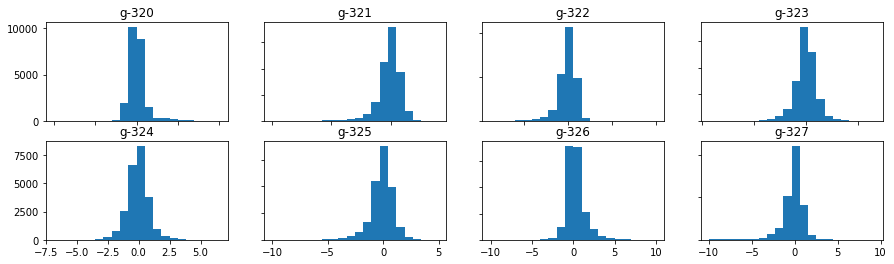

In [35]:
subplot_grid(rows=2,cols=4,bins=20,x_label='Measurement',y_label='Number of Signatures',figsize=(15,4),feature_list=["g-320","g-321","g-322","g-323","g-324","g-325","g-326","g-327"])

From the histogram of the featuers it seems that they are normally distributed. We perform a normality check where the null hypothesis it that he features comes from normal distribution. We can reject the null with confidence 5%.

In [36]:
def test_normality(df,p_value):
    features_normal = 0
    columns  =0
    for column in df:
        if df[column].dtype!='O':
            columns = columns +1
            stat, p = normaltest(df[column])
            if p>=p_value:
                features_normal = features_normal+1
                print(f"Column {column} comes from normal distribution with p-value {p}")
    print(f"Number of features where normal distribution cannot be rejected: {features_normal}")   
    print(f"Number of features where normal distribution can be rejected: {columns-features_normal}") 

In [37]:
test_normality(train_features,0.05)

Number of features where normal distribution cannot be rejected: 0
Number of features where normal distribution can be rejected: 873


In order to save computational memory we will make a custom correlation half matrix. We choose Spearman since the method is more robust to nonnormality of distribution. To make reading the matrix easier, we set up a threshold for which we want the function to count the number of features above and below it.

In [16]:
def correlation_half_matrix(df,coef_threshold,method):
    """Correlation half matrix"""
    dct = {'feature1':[],'feature2':[],'corr':[]}
    num_correlations = 0
    for ind, col1 in  enumerate(df.columns):
        for col2 in df.columns[ind+1:]:
            corr = df[col1].corr(df[col2], method=method)
            dct['feature1'].append(col1)
            dct['feature2'].append(col2)
            dct['corr'].append(corr)
            if corr>=coef_threshold or corr<=-coef_threshold:
                num_correlations = num_correlations+1
                print(f"Columns: {col1}, {col2} Correlation coefficient: {corr}")
            del corr    
    print(f"Number of correlations with coefficient greater or equal to [{coef_threshold}]: {num_correlations}")
    print(f"Number of correlations with coefficient less than [{coef_threshold}]: {len(df.columns)-num_correlations}")
    df = pd.DataFrame(dct)
    return df
    

In [ ]:
corr_matrix= correlation_half_matrix(train_features,0.05)
corr_matrix.to_csv("corr_matrix.csv")

In [5]:
corr_matrix=pd.read_csv("corr_matrix.csv")

From the histogram, almost all features' correlations are between -0.4 and 0.4.

Text(0.5, 0, 'Correlation coefficient')

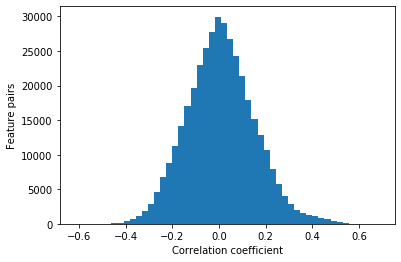

In [17]:
plt.hist(corr_matrix.iloc[:,3],bins=50)
plt.ylabel('Feature pairs')
plt.xlabel('Correlation coefficient')

### 2.Methodology

  A simple to complex approach is applied where each target is modelled independantly from other targets. The underlying assumption is that the targets might be affected differently and if, for example, for one target the best descriptive relationship might be linear, for another it might be exponential or logarithmic. Theoretically, in this case there will be up to 206 different models best describing each target while the rest of the targets are not employed as an input variables.
   A dataframe matrix is created where the columns are the 206 targets and each row contains an instance object. The instance represents the best estimated model that the grid search has determined for the respective target and type of model. 
  
   #### 2.0 Target and Feature Preprocessing

   #### 2.1 Target Selection: Simplified procedure in the context of lack of computational capacities.
Due to limitations of the computational capacities to estimate for 206 targets, a nonrepresentatiove sample of 6 targets is employed. The goal is to build a valid methodology that can be applied to the to the full scope in case we have the computational capacity to do so.The methodology remains unchanged. 
The samples are: median of the distribution and one median absolute deviation to the right and left of the median. The median estimate is chosen due to its robustness in the context of outliers.  
A function is created that uses a grid search with stratified k fold split and returns the best model based on the chosen scoring strategy.

   #### 2.2 Feature Engineering: Dummy Variables for Categorical Data.
For the three categorical variables we will create dummies. For each category we will drop baseline dummies to avoid collinearity. The dropped dummies will be included in the model intercept as a baseline.   
   
   #### 3.0 Models. 
   
   #### 3.1 Logistic Regression. 
   Logistic regression is an elegant mathematical transforamtion of the linear regression to provide the probability of an event. The model in essense is linear as it assumes linearity of independent variables and log odds. Logreg can be used for mixed dummy and continous independent variables. Independent variables should not be linearly correlated.
   #### 3.2 Linear SVM with Feature Selection
   The Linear SVM chooses a line that best separates classes in the multidimensional space. In order to optimize the model we reduce the number of features. The method is Select Percentile class that uses the function mutual_info_classif. The Select Percentile keeps the top percentile features. mutual_info_classif ranks the importance of features by measuring the dependency between the variables. The function is based on entropy estimation from k-nearest neighbors distances.
   #### 3.3 Random Forest
   A standard random forest is fitted to the training set with no feature selection.
   #### 3.4  Logistic Regression with Under and Over Sampling.
   A rule of thumb for linear modeling is that the number of features should not exceed the number of samples. As an example, if we consider the meadian case, we have 39 positives to 23775 negatives(bcr-abl_inhibitor) and for the mean case, the ratio is 81 positives to 23733 negaitives. In case of undersampling with 1:1 ratio and no feature extraction there will be 78 samples in the meadian case and 162 samples in the mean case. Therefore, a preferred approach is to perform oversampling and undersampling combined. Since there is no memory to perform first overampling we perform undersampling first instead. 
   
   #### 3.5 Models Performace.
   Models are scored on train and validation test sets using f1 score.
  
   

--------------------------------------------------------------------------------------

#### 1.1 Target Selection: Simplified procedure in the context of lack of computational capacities.

If we take for measure one median absolute deviation to the left, then we will have a target with just 1 positive observation. We will substitute the observation and instead, for the left tail, we will take a target with 6 positive observations (they are 16 out of 206) and 18 positive observations (they are 13 out of 206).

In [5]:
array_ones= np.count_nonzero(train_targets==1, axis=0)
mean = np.mean(array_ones)
med = np.median(array_ones)
std = array_ones.std()
mad = median_absolute_deviation(array_ones)
print('Mean:',mean)
print('Median:',med)
print('Standard deviation:',std)
print("Median absolute deviation:", mad)
six = 0
eightn = 0
train_targets_reduced = pd.DataFrame()
for col in train_targets.columns:
    if train_targets[col].sum()==np.floor(med) or train_targets[col].sum()==np.ceil(med):
        train_targets_reduced[col]=train_targets[col]
        print("Median added:",col)
    if train_targets[col].sum()==round(med+mad-2):
        train_targets_reduced[col]=train_targets[col]
        print("Median absolute deviation to the right added:",col)
    if train_targets[col].sum()==6 and six ==0:
        train_targets_reduced[col]=train_targets[col]
        six = 1
        print("Target with 6 positive observations added:",col)
    if train_targets[col].sum()==18 and eightn ==0:
        train_targets_reduced[col]=train_targets[col]
        eightn = 1
        print("Target with 18 positive observations added:",col)
print("Shape of reduced target dataframe:", train_targets_reduced.shape)        

Mean: 81.76699029126213
Median: 38.5
Standard deviation: 114.88049543219893
Median absolute deviation: 37.8063
Target with 18 positive observations added: 11-beta-hsd1_inhibitor
Target with 6 positive observations added: antiarrhythmic
Median added: bcr-abl_inhibitor
Median absolute deviation to the right added: glutamate_receptor_agonist
Median absolute deviation to the right added: membrane_integrity_inhibitor
Median added: vitamin_d_receptor_agonist
Shape of reduced target dataframe: (23814, 6)


In [72]:
train_targets_reduced.to_csv("train_targets_reduced.csv")

#### 1.2 Feature Engineering: Dummy Variables for Categorical Data

In [6]:
train_features_dummies=pd.get_dummies(train_features, columns=['cp_type','cp_dose','cp_time'])
train_features_b_dummies=train_features_dummies.drop(columns=['cp_type_ctl_vehicle', 'cp_time_24','cp_dose_D1'])

In [7]:
train_features_b_dummies.head(5)

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,c-94,c-95,c-96,c-97,c-98,c-99,cp_type_trt_cp,cp_dose_D2,cp_time_48,cp_time_72
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,0,0,0
id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,1,0,0,1
id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,1,0,1,0
id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,1,0,1,0
id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,1,0,1


In [6]:
train_features_b_dummies.shape

(23814, 876)

The function below initializes a grid search with stratified kfold split for a custom model. Returns the best estimated model based on the chosen scoring strategy.

In [7]:
def grid_search_cross_validation_multiple_targets(model, params, scoring, n_splits,x_train,y_train):
    """A function that takes as params initialized model object, parameters for the grid search, scoring strategy of the grid search,
    number of splits for the cross validation, train features and train target. Returns the best estimated model."""
    k_fold = StratifiedKFold(n_splits = n_splits)
    grid_search = GridSearchCV(model, params, scoring = scoring, cv = k_fold.split(x_train, y_train))
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [7]:
def grid_search_cross_validation_multiple_targets_returngrid(model, params, scoring, n_splits,x_train,y_train):
    """A function that takes as params initialized model object, parameters for the grid search, scoring strategy of the grid search,
    number of splits for the cross validation, train features and train target. Returns the grid."""
    k_fold = StratifiedKFold(n_splits = n_splits)
    grid_search = GridSearchCV(model, params, scoring = scoring, cv = k_fold.split(x_train, y_train))
    grid_search.fit(x_train, y_train)
#     best_model = grid_search.best_estimator_
    return grid_search

#### 2.1 Logistic Regression

In [21]:
train_targets_reduced=pd.read_csv("train_targets_reduced.csv")

In [9]:
params_LogReg = {
    "C": [0.001,0.01,0.1,1,10,100], 
    "solver": ['saga',  'lbfgs'],
}

In [9]:
print(datetime.datetime.now())
model_list_LogReg_reduced={}
for key, value in train_targets_reduced.iteritems():
    try:
        model_list_LogReg_reduced[key]=grid_search_cross_validation_multiple_targets(LogisticRegression(multi_class='auto'), params_LogReg, 'f1', 3,train_features_b_dummies,value)
    except Exception as e:
        print(e)    
with open('model_list_logreg_reduced_auto.pickle', 'wb') as handle:
    pickle.dump(model_list_LogReg_reduced, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(datetime.datetime.now())  

2020-11-11 19:19:13.627605


c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appda

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appda

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appda

2020-11-11 20:10:08.120440


c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
model_list_logreg_reduced = pd.read_pickle(r'model_list_logreg_reduced_auto.pickle')

In [24]:
model_list_logreg_reduced

{'11-beta-hsd1_inhibitor': LogisticRegression(C=0.001, solver='saga'),
 'antiarrhythmic': LogisticRegression(C=0.001, solver='saga'),
 'bcr-abl_inhibitor': LogisticRegression(C=10),
 'glutamate_receptor_agonist': LogisticRegression(C=0.001, solver='saga'),
 'membrane_integrity_inhibitor': LogisticRegression(C=100),
 'vitamin_d_receptor_agonist': LogisticRegression(C=100)}

#### 2.2 Linear SVM with Feature Selection

In [8]:
params_LSVM={
    "C":[0.1, 0.5, 1, 10, 50],     
}

In [9]:
train_targets_reduced.head(5)

,11-beta-hsd1_inhibitor,antiarrhythmic,bcr-abl_inhibitor,glutamate_receptor_agonist,membrane_integrity_inhibitor,vitamin_d_receptor_agonist
sig_id,,,,,,
id_000644bb2,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0
id_000a6266a,0,0,1,0,0,0
id_0015fd391,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0


In [ ]:
#SelectPercentile computes the ANOVA F-value. The independent variables in ANOVA must be categorical variables Preserves the specified precentile of features with highest score

In [10]:
print(datetime.datetime.now())

model_list_LSVM_reduced={}
for key, value in train_targets_reduced.iteritems():    
        try:
            print("1 ",key)
            x1 = SelectPercentile(mutual_info_classif, percentile=10).fit_transform(train_features_b_dummies.iloc[:,0:438], value)
            x2 = SelectPercentile(mutual_info_classif, percentile=10).fit_transform(train_features_b_dummies.iloc[:,438:876], value)
            x = np.concatenate((x1, x2),axis=1)

            model_list_LSVM_reduced[key]=grid_search_cross_validation_multiple_targets(SVC(kernel='linear'), params_LSVM, 'f1', 3,x,value)

            print("2 ",model_list_LSVM_reduced[key])
        except Exception as e:
            print(str(e))
            continue    
with open('model_list_LSVM_reduced0.pickle', 'wb') as handle:
    pickle.dump(model_list_LSVM_reduced, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(datetime.datetime.now())     
#     print(type(value))

2020-11-11 09:50:52.530607
1  vitamin_d_receptor_agonist
2  SVC(C=0.1, kernel='linear')
2020-11-11 09:55:57.722400


#### Random Forest

In [8]:
# max_depth - the longest path between the root node and the leaf node
# n_estimators - the number of trees

params_RF={
    "n_estimators":[50, 100, 200],
    "max_depth":[20, 50, 100],
}

In [10]:
print(datetime.datetime.now())
model_list_RF={}
for key, value in train_targets_reduced.iteritems(): 
        print(key)
        try:
            model_list_RF[key]=grid_search_cross_validation_multiple_targets(RandomForestClassifier(), params_RF, 'f1', 3,train_features_b_dummies,value)
        except:
            continue
        
with open('model_list_RF_reduced.pickle', 'wb') as handle:
    pickle.dump(model_list_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(datetime.datetime.now())  

2020-11-11 10:38:19.006940
antiarrhythmic
bcr-abl_inhibitor
glutamate_receptor_agonist
membrane_integrity_inhibitor
vitamin_d_receptor_agonist
2020-11-11 12:10:38.413646


#### 3.1 Logistic Regression with Under and Over Sampling

In [ ]:
ones= np.count_nonzero(train_targets_reduced==1, axis=0)
np.unique(ones,return_counts=True)

In [ ]:
print(datetime.datetime.now())
ratios = [0.003,0.006,0.02,0.02,0.04,0.04]
model_list_LogReg_reduced_over_under={}
model_estimates_train = defaultdict(list)

for key, value in train_targets_reduced.iteritems():
    
    undersample = RandomUnderSampler(sampling_strategy=ratios[i])
    oversample = SMOTE(sampling_strategy=0.5)
    
        steps = [('u', undersample),('o', oversample)]
        pipeline = Pipeline(steps=steps)
    
        try:
            x, y = pipeline.fit_resample(train_features_b_dummies, value)
     
            model=grid_search_cross_validation_multiple_targets_returngrid(LogisticRegression(multi_class='auto'), params_LogReg, 'f1', 3,x,y)
            model_list_LogReg_reduced_over_under[key] = model.best_estimator_
            model_estimates_train['model_logreg_over_under'].append(model.best_score_)
        
        except Exception as e:
            print(e)    
with open('model_list_logreg_reduced_auto_over_under2.pickle', 'wb') as handle:
    pickle.dump(model_list_LogReg_reduced_over_under, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_estimates_train=pd.DataFrame(model_estimates_train)
model_estimates_train.to_csv("model_estimates_train_logreg_over_under2.csv")
print(datetime.datetime.now()) 

#### 2.0 Model Evaluation

#### 2.1 Check for Under/Overfitting

In [8]:
model_list_logreg_reduced = pd.read_pickle(r'model_list_logreg_reduced_auto.pickle')
model_list_logreg_reduced_under_over = pd.read_pickle(r'model_list_logreg_reduced_auto_over_under2.pickle')
model_list_LSVM_reduced = pd.read_pickle(r'model_list_LSVM_reduced0.pickle')
model_list_RF_reduced = pd.read_pickle(r'model_list_RF_reduced.pickle')


In [14]:
model_estimates_train = defaultdict(list)
model_estimates_validate = defaultdict(list)

for key,value in train_targets_reduced.iteritems():
    
    model_logreg = model_list_logreg_reduced[key]
    model_logreg_under_over = model_list_logreg_reduced_under_over[key]
    model_RF = model_list_RF_reduced[key]
    
    train_features_train, train_features_validate, train_targets_train, train_targets_validate = train_test_split(
    train_features_b_dummies, value, train_size = 0.7, stratify = value)
    
    model_logreg.fit(train_features_train, train_targets_train)
    model_logreg_under_over.fit(train_features_train, train_targets_train)
    model_RF.fit(train_features_train, train_targets_train)


    model_estimates_train['model_logreg'].append(model_logreg.score(train_features_train, train_targets_train))
    model_estimates_validate['model_logreg'].append(f1_score(train_targets_validate, model_logreg.predict(train_features_validate)))
    
    model_estimates_train['model_logreg_under_over'].append(model_logreg_under_over.score(train_features_train, train_targets_train))
    model_estimates_validate['model_logreg_under_over'].append(f1_score(train_targets_validate, model_logreg_under_over.predict(train_features_validate)))
    
    model_estimates_train['model_RF'].append(model_RF.score(train_features_train, train_targets_train))
    model_estimates_validate['model_RF'].append(f1_score(train_targets_validate, model_RF.predict(train_features_validate)))

model_estimates_train=pd.DataFrame(model_estimates_train)
model_estimates_validate=pd.DataFrame(model_estimates_validate)

model_estimates_train.to_csv("model_estimates_train2.csv")
model_estimates_validate.to_csv("model_estimates_validate2.csv")    

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

In [15]:
model_estimates_train = pd.read_csv('model_estimates_train2.csv')
model_estimates_validate=pd.read_csv('model_estimates_validate2.csv')   

In [16]:
model_estimates_validate

,Unnamed: 0,model_logreg,model_logreg_under_over,model_RF
0,0,0.000000,0.000000,0.0
1,1,0.000000,0.000000,0.0
2,2,0.428571,0.428571,0.0
3,3,0.000000,0.000000,0.0
4,4,0.000000,0.000000,0.0
5,5,0.470588,0.153846,0.0


In [17]:
model_estimates_train

,Unnamed: 0,model_logreg,model_logreg_under_over,model_RF
0,0,0.99922,1.00000,1.00000
1,1,0.99976,1.00000,1.00000
2,2,1.00000,1.00000,1.00000
3,3,0.99688,0.99892,0.99982
4,4,1.00000,0.99844,0.99994
5,5,1.00000,0.99898,1.00000


--------------------------------------
Drafts

#### Logistic Regression with PCA

In [63]:
def PCA_batches(df,percent_threshold,n_components,*args):
    """args is a list with the boundaires of the df for which PCA will be applied"""
    batch_list = []
    pca_list  =[]
    for index in range(len(args)-1):
        df_PCA = df.iloc[:,args[index]:args[index+1]]
        batch_list.append(df_PCA)
    for batch in batch_list:
        pca = PCA(n_components=n_components).fit_transform(batch)
        pca_df = pd.DataFrame(pca)
        pca_list.append(pca_df)
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), pca_list) 
    return df_final




In [64]:
PCA_df = PCA_batches(train_features_b_dummies,'percent_threshold',3,0,300,600,800,872)

In [65]:
PCA_df.head(5)

,0_x,1_x,2_x,0_y,1_y,2_y,0_x,1_x,2_x,0_y,1_y,2_y
0,-5.723137,0.533568,-0.653711,-4.935411,-1.298509,-1.328726,-5.130583,0.282565,-3.944394,-6.190893,-0.074689,0.347022
1,-4.067255,1.361307,5.590406,-4.309550,3.364243,6.069413,-5.346431,0.760029,1.804479,-6.050393,-0.671079,0.106307
2,-0.773748,2.521646,-1.452083,-0.119953,0.898035,0.732229,-2.549519,0.891472,2.155023,-1.972984,0.310375,0.576631
3,5.968533,-2.167132,-3.226692,5.375589,-3.518999,-0.393909,9.176148,-3.364282,3.820734,11.238751,6.424056,-0.123428
4,-5.165412,1.268963,5.181918,-4.853418,-0.427602,4.733241,-3.979105,-1.179680,2.714048,-5.293675,0.898601,0.054930


In [73]:
df_final_miss_features=PCA_df_final.isnull().sum().sum()

In [74]:
df_final_miss_features

0

In [71]:
train_dummies = train_features_b_dummies.iloc[:,-4::]
train_dummies=train_dummies.reset_index(drop=True)
PCA_df_final = pd.merge(PCA_df, train_dummies, left_index=True, right_index=True, how='outer')

In [72]:
PCA_df_final.head(5)

,0_x,1_x,2_x,0_y,1_y,2_y,0_x,1_x,2_x,0_y,1_y,2_y,cp_type_trt_cp,cp_dose_D2,cp_time_48,cp_time_72
0,-5.723137,0.533568,-0.653711,-4.935411,-1.298509,-1.328726,-5.130583,0.282565,-3.944394,-6.190893,-0.074689,0.347022,1,0,0,0
1,-4.067255,1.361307,5.590406,-4.309550,3.364243,6.069413,-5.346431,0.760029,1.804479,-6.050393,-0.671079,0.106307,1,0,0,1
2,-0.773748,2.521646,-1.452083,-0.119953,0.898035,0.732229,-2.549519,0.891472,2.155023,-1.972984,0.310375,0.576631,1,0,1,0
3,5.968533,-2.167132,-3.226692,5.375589,-3.518999,-0.393909,9.176148,-3.364282,3.820734,11.238751,6.424056,-0.123428,1,0,1,0
4,-5.165412,1.268963,5.181918,-4.853418,-0.427602,4.733241,-3.979105,-1.179680,2.714048,-5.293675,0.898601,0.054930,1,1,0,1


In [80]:
moa_features_train, moa_features_validate,moa_targets_train_2,moa_targets_validate_2 = train_test_split(PCA_df_final,train_targets_0,train_size = 0.7,stratify=train_targets_0)
log_reg_2 = LogisticRegression(C=10)
log_reg_2 = log_reg_2.fit(moa_features_train,moa_targets_train_2)
accuracy_score = log_reg_2.score(moa_features_validate,moa_targets_validate_2)
ascore=metrics.accuracy_score(moa_targets_validate_2,log_reg_2.predict(moa_features_validate))
fscore=metrics.f1_score(moa_targets_validate_2,log_reg_2.predict(moa_features_validate))

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
fscore

0.0

In [79]:
accuracy_score

0.9874037788663401

In [59]:
tt('df',1,3,4,5)

df
(1, 3, 4, 5)
range(0, 4)


In [42]:
batch_one = train_features_b_dummies.iloc[:,0:300]
batch_two = train_features_b_dummies.iloc[:,301:600]
batch_three = train_features_b_dummies.iloc[:,601:800]
batch_four = train_features_b_dummies.iloc[:,801:872]


In [47]:
train_features_b_dummies.iloc[0:5,870:873]

,c-98,c-99,cp_type_trt_cp
sig_id,,,
id_000644bb2,0.3801,0.4176,1
id_000779bfc,0.6077,0.7371,1
id_000a6266a,-1.4080,0.6931,1
id_0015fd391,-0.3876,-0.8154,1
id_001626bd3,-0.3786,0.7125,1


In [57]:
batch_three.head(5)

,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,-0.2136,-0.6129,0.4357,1.2690,-0.3858,0.8604,0.0958,3.3940,-0.0452,0.6513,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,0.8543,1.2990,-1.1020,-0.6565,-1.0050,-0.8245,-0.9344,1.1400,0.8501,-0.7063,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,-0.3010,2.8890,1.3400,1.4570,4.4760,-1.5700,0.6040,2.2500,0.2751,-0.2307,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,-1.8150,-0.8354,1.7400,-0.4051,0.4205,1.8750,0.8082,-1.5450,-1.3680,0.3007,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,0.8249,-0.0131,0.0000,0.9043,0.1662,-0.3453,1.3360,-0.3655,-0.6961,-0.4308,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [43]:
pca_one = PCA(n_components=5).fit(batch_one)
pca_two = PCA(n_components=5).fit(batch_two)
pca_three = PCA(n_components=5).fit(batch_three)
pca_four_1 = PCA(n_components=5).fit(batch_four_1)

In [44]:
print(pca_one.explained_variance_ratio_)
print(pca_two.explained_variance_ratio_)
print(pca_three.explained_variance_ratio_)
print(pca_four_1.explained_variance_ratio_)


[0.32770748 0.05083023 0.03325614 0.02710047 0.02460508]
[0.28062958 0.04749156 0.03269229 0.02955473 0.02317879]
[0.43511607 0.03444596 0.02538106 0.02125228 0.02102561]
[0.84822599 0.01118344 0.00856168 0.00662918 0.00509189]


In [45]:
train_one = pca_one.transform(batch_one)
train_one_df = pd.DataFrame(train_one)
train_two = pca_two.transform(batch_two)
train_two_df = pd.DataFrame(train_two)
train_three = pca_three.transform(batch_three)
train_three_df = pd.DataFrame(train_three)
train_four = pca_four_1.transform(batch_four_1)
train_four_df = pd.DataFrame(train_four)

In [46]:
train_five_df = train_features_b_dummies.iloc[:,-4::]
train_five_df=train_five_df.reset_index(drop=True)

In [64]:
train_five_df.head(5)

,cp_type_trt_cp,cp_dose_D2,cp_time_48,cp_time_72
0,1,0,0,0
1,1,0,0,1
2,1,0,1,0
3,1,0,1,0
4,1,1,0,1


In [47]:
dfs = [train_one_df, train_two_df, train_three_df, train_four_df,train_five_df]

In [48]:
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), dfs)

In [54]:
df_final.describe()

,0_x,1_x,2_x,3_x,4_x,0_y,1_y,2_y,3_y,4_y,...,4_x,0_y,1_y,2_y,3_y,4_y,cp_type_trt_cp,cp_dose_D2,cp_time_48,cp_time_72
count,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,23814.000000,...,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,2.381400e+04,5.0,5.000000,5.000000,5.000000
mean,-2.864370e-17,4.057857e-17,4.773950e-18,-3.222416e-17,-1.790231e-18,1.909580e-17,-1.909580e-17,1.193487e-18,2.088603e-17,0.000000,...,-1.193487e-18,-3.437244e-16,1.909580e-17,1.253162e-17,-1.790231e-18,1.163650e-17,1.0,0.200000,0.400000,0.400000
std,1.244796e+01,4.902482e+00,3.965435e+00,3.579673e+00,3.410887e+00,1.090857e+01,4.487550e+00,3.723264e+00,3.540092e+00,3.135064,...,2.719167e+00,1.468869e+01,1.686612e+00,1.475730e+00,1.298546e+00,1.138070e+00,0.0,0.447214,0.547723,0.547723
min,-1.058428e+01,-3.303776e+01,-2.761524e+01,-1.946286e+01,-2.429581e+01,-9.643162e+00,-2.810857e+01,-2.030038e+01,-2.965857e+01,-20.420271,...,-1.430184e+01,-2.812005e+01,-6.167411e+00,-7.691083e+00,-7.585031e+00,-7.741625e+00,1.0,0.000000,0.000000,0.000000
25%,-4.658164e+00,-5.962459e-01,-1.795878e+00,-1.572020e+00,-1.721755e+00,-4.296404e+00,-6.526442e-01,-1.893137e+00,-1.965562e+00,-1.328586,...,-1.533016e+00,-5.757927e+00,-6.360690e-01,-5.870047e-01,-5.677250e-01,-4.992804e-01,1.0,0.000000,0.000000,0.000000
50%,-3.551164e+00,5.701192e-01,1.411947e-01,-4.860308e-02,-7.886032e-02,-3.279072e+00,4.003440e-01,7.819578e-02,6.672985e-02,-0.188821,...,-4.136600e-02,-3.789666e+00,-1.860991e-01,-1.036299e-01,-1.088893e-01,-4.510919e-02,1.0,0.000000,0.000000,0.000000
75%,-2.033061e+00,1.576018e+00,2.014944e+00,1.419960e+00,1.652765e+00,-1.778540e+00,1.305364e+00,2.001572e+00,2.029174e+00,1.007580,...,1.497076e+00,-1.268764e+00,2.974075e-01,3.974713e-01,4.067373e-01,4.103897e-01,1.0,0.000000,1.000000,1.000000
max,7.515219e+01,3.388349e+01,2.880539e+01,2.995750e+01,3.575685e+01,6.832289e+01,3.606325e+01,2.521791e+01,3.111762e+01,23.530678,...,2.253682e+01,7.850483e+01,1.641736e+01,1.291604e+01,1.008105e+01,1.455192e+01,1.0,1.000000,1.000000,1.000000


In [56]:
df_final_miss_features=df_final.isnull().sum().sum()
df_final_miss_features

95236

In [29]:
train_targets_0=train_targets.iloc[:,4]

In [70]:
moa_features_train, moa_features_validate,moa_targets_train_0,moa_targets_validate_0 = train_test_split(train_features_b_dummies,train_targets_0,train_size = 0.7,stratify=train_targets_0)

In [71]:
log_reg_0 = LogisticRegression(C=1)
log_reg_0 = log_reg_0.fit(moa_features_train,moa_targets_train_0)
accuracy_score = log_reg_0.score(moa_features_validate,moa_targets_validate_0)
accuracy_score

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9764870538838348

In [38]:
prediction = log_reg_0.predict(moa_features_validate)
np_ones_0= np.count_nonzero(prediction, axis=0)
np_ones_0

80

In [79]:
f1_score=  metrics.f1_score(moa_targets_validate_0,log_reg_0.predict(moa_features_validate))

In [80]:
f1_score

0.011764705882352941

In [81]:
ascore=metrics.accuracy_score(moa_targets_validate_0,log_reg_0.predict(moa_features_validate))

In [82]:
ascore

0.9764870538838348

In [41]:
prediction[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [50]:
moa_features_train_pca, moa_features_validate_pca,moa_targets_train_0,moa_targets_validate_0 = train_test_split(df_final,train_targets_0,train_size = 0.7,stratify=train_targets_0)

In [51]:
log_reg_0 = LogisticRegression(C=1e6)
log_reg_0 = log_reg_0.fit(moa_features_train_pca,moa_targets_train_0)
accuracy_score = log_reg_0.score(moa_features_validate_pca,moa_targets_validate_0)
accuracy_score

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
prediction = log_reg_0.predict(moa_features_validate)
np_ones_0= np.count_nonzero(prediction, axis=0)
np_ones_0

In [43]:
ipca = IncrementalPCA(batch_size=10).fit(train_features_b_dummies)
# train_features_b_dummies_pca = pca.transform(train_features_b_dummies)


MemoryError: 

In [69]:
train_targets_0=train_targets.iloc[:,0]

In [70]:
train_targets_0.head(5)

sig_id
id_000644bb2    0
id_000779bfc    0
id_000a6266a    0
id_0015fd391    0
id_001626bd3    0
Name: 5-alpha_reductase_inhibitor, dtype: int64

In [71]:
moa_features_train, moa_features_validate,moa_targets_train_0,moa_targets_validate_0 = train_test_split(train_features_b_dummies,train_targets_0,train_size = 0.7,stratify=train_targets_0)

In [74]:
moa_targets_train_0.head(5)

sig_id
id_8e129929f    0
id_7b799c0a0    0
id_b3cdf9013    0
id_85f34ba96    0
id_ddb909340    0
Name: 5-alpha_reductase_inhibitor, dtype: int64

In [72]:
log_reg_0 = LogisticRegression(C=1e6)
log_reg_0 = log_reg_0.fit(moa_features_train,moa_targets_train_0)

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MemoryError: 

In [28]:
accuracy_score = log_reg_0.score(moa_features_validate,train_targets_0)

In [29]:
accuracy_score

0.9993002099370188

In [30]:
prediction = log_reg_0.predict(moa_features_validate)

In [38]:
np_ones_0= np.count_nonzero(prediction, axis=0)

In [39]:
np_ones_0

0

In [90]:
linda = LinDA(n_components=2)

In [91]:
linda.fit(train_features_b_dummies.iloc[:,1:10], train_targets_0)

c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(9, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\ynche\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [92]:
isomap = Isomap(n_components = 10, n_neighbors = 10)

In [95]:
iris_isomap = isomap.fit_transform(train_features_b_dummies.iloc[:,1:100])

MemoryError: 